In [13]:
import os
from pathlib import Path
import sys
import time
from functools import partial
from tqdm import tqdm

pwd = Path(os.getcwd())
sys.path.append(str(pwd.parent.parent / "gym-checkers-for-thai"))

In [14]:
from checkers.agents.baselines import play_a_game, RandomPlayer
from checkers.game import Checkers
from checkers.agents import Player
from checkers.agents.alpha_beta import MinimaxPlayer, first_order_adv

from player import GADQNPlayer
from model import DQN

import pygad
import pygad.torchga
import torch

import mlflow
import mlflow.pytorch

import numpy as np

In [15]:
MINIMAX_SEARCH_DEPTH = 2
WEIGHT_FOLDER = pwd / "weights" / f"vs_depth_{MINIMAX_SEARCH_DEPTH}"

# pygad config
N_MATCHES = 55
N_SOLUTIONS = 10
N_GENERATIONS = 100

In [16]:
# Create the folder if it doesn't exist
WEIGHT_FOLDER.mkdir(parents=True, exist_ok=True)

In [17]:
def run_experiment(model, n_matches=10, max_game_len=100, time_limit=10):
    n_wins, n_draws, n_losses = 0, 0, 0
    stime = time.time()

    # delete after end the loop
    looper = tqdm(range(n_matches), unit="matches", leave=False)
    for i in looper:
        ch = Checkers()

        # GA tuned model function
        black_player = GADQNPlayer('black', model=model)

        # Random player function
        # white_player = RandomPlayer('white', seed=i)

        # Minimax player function
        white_player = MinimaxPlayer('white', 
                                     partial(first_order_adv, 'white', 86, 54.5, 87, 26),
                                     search_depth=MINIMAX_SEARCH_DEPTH)
        

        #modify this function to put our RL model as white
        winner = play_a_game(ch, black_player.next_move, white_player.next_move, max_game_len, is_show_detail=False)

        # Keep scores
        n_wins += 1 if winner == 'black' else 0
        n_draws += 1 if winner is None else 0
        n_losses += 1 if winner == 'white' else 0

        looper.set_postfix(
            wins=n_wins,
            draws=n_draws,
            losses=n_losses,
        )
        
        if time.time() - stime > time_limit*60:
            break
    
    return n_wins, n_draws, n_losses, black_player.n_moves, black_player.n_combo_kill

In [18]:
max_fitness_score = 0

def on_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Best fitness = {fitness}".format(fitness=ga_instance.best_solution()[1]))

def on_fitness(ga_instance, population_fitness):
    global max_fitness_score, last_generation_time

    use_time = time.time() - last_generation_time

    # update step progress
    mlflow.log_metric("best_fitness", ga_instance.best_solution()[1], step=ga_instance.generations_completed)
    mlflow.log_metric("mean_fitness", np.mean(population_fitness), step=ga_instance.generations_completed)
    mlflow.log_metric("std_fitness", np.std(population_fitness), step=ga_instance.generations_completed)
    mlflow.log_metric("time", use_time, step=ga_instance.generations_completed)

    # save the best solution
    solution, best_fitness, _ = ga_instance.best_solution()
    if best_fitness > max_fitness_score:
        model = DQN()
        model_weights_dict = pygad.torchga.model_weights_as_dict(model=model, weights_vector=solution)
        model.load_state_dict(model_weights_dict)

        n_win, _, _, _, _ = run_experiment(model, n_matches=N_MATCHES)
        win_rate = n_win / N_MATCHES

        mlflow.log_metric("win_rate", win_rate, step=ga_instance.generations_completed)

        torch.save(model.state_dict(), f'{WEIGHT_FOLDER}/DQL_with_fitness{best_fitness:.2f}_winrate{win_rate*100:.2f}_generation{ga_instance.generations_completed}.pth')
        print("Model saved")

        mlflow.pytorch.log_model(model, "models")

        max_fitness_score = best_fitness
    
    last_generation_time = time.time()

In [19]:
def fitness_func(ga_instance, solution, solution_idx):

    model = DQN()
    model_weights_dict = pygad.torchga.model_weights_as_dict(model=model, weights_vector=solution)
    model.load_state_dict(model_weights_dict)

    n_wins, n_draws, n_losses, n_moves, n_combo_kill = run_experiment(model, n_matches=N_MATCHES, max_game_len=100, time_limit=2)

    win_score = 2
    draw_score = 1
    loss_score = 0
    move_penalty = 0.01
    combo_kill_bonus = 0.1

    total_score = n_wins * win_score
    total_score += n_draws * draw_score
    total_score += n_losses * loss_score
    total_score -= n_moves * move_penalty
    total_score += n_combo_kill * combo_kill_bonus

    return total_score

In [20]:
torch_ga = pygad.torchga.TorchGA(model=DQN(),
                                 num_solutions=N_SOLUTIONS)

ga_instance = pygad.GA(num_generations=N_GENERATIONS,
                       num_parents_mating=5,
                       initial_population = torch_ga.population_weights,
                       fitness_func=fitness_func,
                       parent_selection_type="sss",
                       crossover_type="single_point",
                       mutation_type="random",
                       mutation_percent_genes=15,
                       keep_parents=-1,
                       on_generation=on_generation,
                       on_fitness=on_fitness)

/Users/jirayuwat/anaconda3/envs/pattern_project/lib/python3.9/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


In [21]:
mlflow.set_experiment("DQL vs Minimax (GA approach)")
with mlflow.start_run():
    mlflow.log_param("N_MATCHES", N_MATCHES)
    mlflow.log_param("N_SOLUTIONS", N_SOLUTIONS)
    mlflow.log_param("N_GENERATIONS", N_GENERATIONS)
    mlflow.log_param("MINIMAX_SEARCH_DEPTH", MINIMAX_SEARCH_DEPTH)

    last_generation_time = time.time()
    ga_instance.run()

  0%|          | 0/1 [00:00<?, ?matches/s]

Model saved


/Users/jirayuwat/anaconda3/envs/pattern_project/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/jirayuwat/anaconda3/envs/pattern_project/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Generation = 1


Best fitness = -0.07


Generation = 2


Best fitness = 0.5


Generation = 3


Best fitness = 0.5


Generation = 4


Best fitness = 0.5


Generation = 5


Best fitness = 0.5


Generation = 6


Best fitness = 1.9


Generation = 7


Best fitness = 0.5


Generation = 8


Best fitness = 0.5


Generation = 9


Best fitness = 0.5


Generation = 10


Best fitness = 0.5


In [22]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()

print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Parameters of the best solution : [ 0.75978631  0.86275833  1.23876323 ... -0.03820738 -0.00620928
 -0.00973191]
Fitness value of the best solution = 0.5


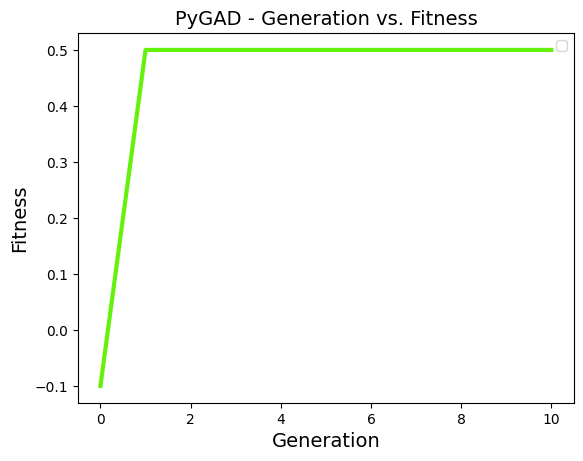

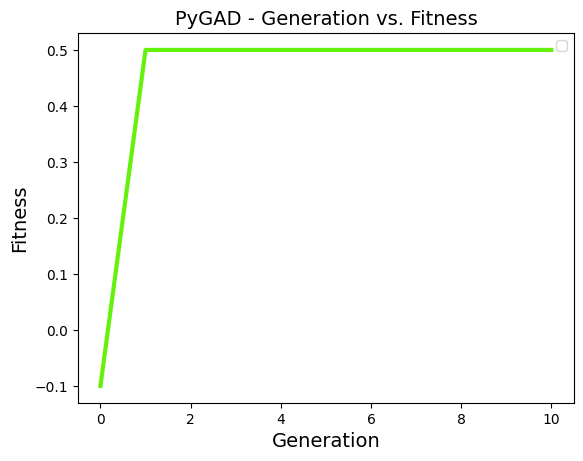

In [23]:
ga_instance.plot_fitness()

In [24]:
ga_instance.save('ga_instance')